<a href="https://colab.research.google.com/github/10944110/AI-Development/blob/main/Midterm_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.IMPORTING DATASET

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    matthews_corrcoef, roc_auc_score, classification_report,
    roc_curve, precision_recall_curve, confusion_matrix,
    ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt

# 讀取 CSV 檔案
df = pd.read_csv("/content/Phishing_Email.csv")

# 顯示前幾筆資料
print(df.head())


   Unnamed: 0                                         Email Text  \
0           0  re : 6 . 1100 , disc : uniformitarianism , re ...   
1           1  the other side of * galicismos * * galicismo *...   
2           2  re : equistar deal tickets are you still avail...   
3           3  \nHello I am your hot lil horny toy.\n    I am...   
4           4  software at incredibly low prices ( 86 % lower...   

       Email Type  
0      Safe Email  
1      Safe Email  
2      Safe Email  
3  Phishing Email  
4  Phishing Email  


In [ ]:
print(df['Email Type'].value_counts())

Email Type
Safe Email        11322
Phishing Email     7312
Name: count, dtype: int64


# 2.DATA PRE-PROCESSING

In [ ]:
# 1. Handle missing values 處理遺失值
df.dropna(subset=['Email Text', 'Email Type'], inplace=True)
df['label'] = df['Email Type'].apply(lambda x: 1 if 'Phishing' in x else 0)

# 2. Text cleaning function 文字清理函數
def clean_text(text):
    text = text.lower()
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'\d+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['clean_text'] = df['Email Text'].apply(clean_text)  # Apply text cleaning 對郵件內容執行清理

# 3. Extract statistical handcrafted features 提取統計型手工特徵
def extract_features(text):
    words = re.findall(r'\b\w+\b', text.lower())
    num_words = len(words)
    num_unique_words = len(set(words))
    stopwords = ["the", "and", "in", "a", "of", "to", "is", "it", "for", "that"]
    num_stopwords = sum(1 for word in words if word in stopwords)
    num_links = len(re.findall(r'http[s]?://|www\.', text))
    num_email_addresses = len(re.findall(r'\S+@\S+', text))
    num_special_chars = len(re.findall(r'[!@#$%^&*?,.:;\'\"()\[\]\{\}\|\\/<>=-]', text))
    num_digits = len(re.findall(r'\d', text))
    urgent_keywords = ["urgent", "verify", "account", "password", "login", "security", "important", "alert"]
    num_urgent_keywords = sum(1 for word in words if word in urgent_keywords)
    avg_word_length = np.mean([len(w) for w in words]) if words else 0
    num_uppercase_words = sum(1 for w in words if w.isupper())

    return pd.Series({
        'num_words': num_words,
        'num_unique_words': num_unique_words,
        'num_stopwords': num_stopwords,
        'num_links': num_links,
        'num_email_addresses': num_email_addresses,
        'num_special_chars': num_special_chars,
        'num_digits': num_digits,
        'num_urgent_keywords': num_urgent_keywords,
        'avg_word_length': avg_word_length,
        'num_uppercase_words': num_uppercase_words
    })

features_df = df['Email Text'].apply(extract_features)

# 4. TF-IDF features TF-IDF 特徵
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
tfidf_matrix = tfidf.fit_transform(df['clean_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out())

# 5. Combine all features 整合所有特徵
X = pd.concat([features_df.reset_index(drop=True), tfidf_df.reset_index(drop=True)], axis=1)
y = df['label']

# 6. Split dataset into training and testing sets 切分訓練與測試資料集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [ ]:
# Check whether the training and testing data splits are balanced
print("Check whether the training and testing data splits are balanced")
print("\nTrain set label distribution:")
print(y_train.value_counts(normalize=True))
print("\nTest set label distribution:")
print(y_test.value_counts(normalize=True))

Check whether the training and testing data splits are balanced

Train set label distribution:
label
0    0.607567
1    0.392433
Name: proportion, dtype: float64

Test set label distribution:
label
0    0.607727
1    0.392273
Name: proportion, dtype: float64


# 3.Training and Testing

In [ ]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# 1. Building and Training Models 建立與訓練模型
model = XGBClassifier(
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)
model.fit(X_train, y_train)

# 2. Finding the Optimal Threshold 找最佳threshold
y_pred_proba = model.predict_proba(X_test)[:, 1]

best_thresh = 0.5
best_mcc = -1
for t in np.arange(0.3, 0.7, 0.01):
    y_temp = (y_pred_proba > t).astype(int)
    mcc = matthews_corrcoef(y_test, y_temp)
    if mcc > best_mcc:
        best_mcc = mcc
        best_thresh = t

y_pred = (y_pred_proba > best_thresh).astype(int)

print(f"Optimal Threshold (by MCC): {best_thresh:.2f}")

Optimal Threshold (by MCC): 0.51


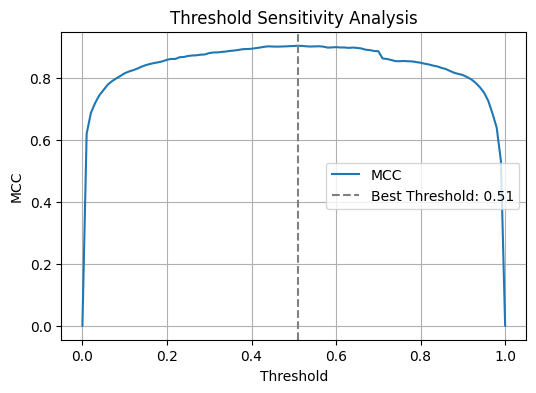

In [ ]:
# Threshold Sensitivity Analysis 門檻靈敏度分析圖
mcc_list = []
thresholds = np.arange(0.0, 1.01, 0.01)
for t in thresholds:
    y_temp = (y_pred_proba > t).astype(int)
    mcc_list.append(matthews_corrcoef(y_test, y_temp))

plt.figure(figsize=(6,4))
plt.plot(thresholds, mcc_list, label="MCC")
plt.axvline(x=best_thresh, color='gray', linestyle='--', label=f'Best Threshold: {best_thresh:.2f}')
plt.xlabel("Threshold")
plt.ylabel("MCC")
plt.title("Threshold Sensitivity Analysis")
plt.legend()
plt.grid(True)
plt.show()



In [ ]:
# 1. EVALUATION METRICS 評估指標
# Classification Report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Safe', 'Phishing']))

print(f"\nAccuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred):.4f}")
print(f"MCC: {matthews_corrcoef(y_test, y_pred):.4f}")
print(f"ROC-AUC: {roc_auc_score(y_test, y_pred_proba):.4f}")




Classification Report:

              precision    recall  f1-score   support

        Safe       0.98      0.94      0.96      2265
    Phishing       0.92      0.97      0.94      1462

    accuracy                           0.95      3727
   macro avg       0.95      0.96      0.95      3727
weighted avg       0.95      0.95      0.95      3727


Accuracy: 0.9528
Precision: 0.9181
Recall: 0.9658
F1-score: 0.9413
MCC: 0.9027
ROC-AUC: 0.9888


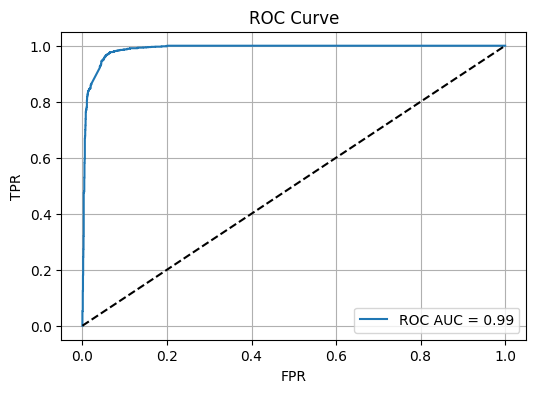

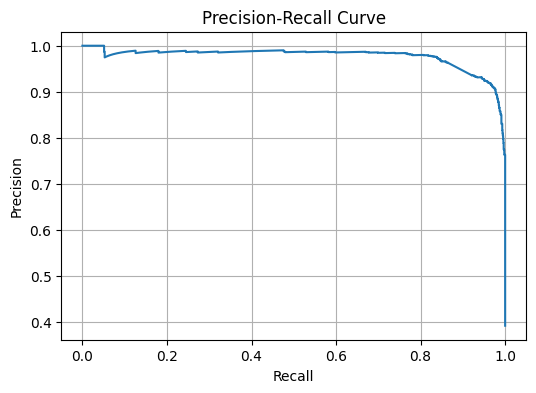

<Figure size 500x400 with 0 Axes>

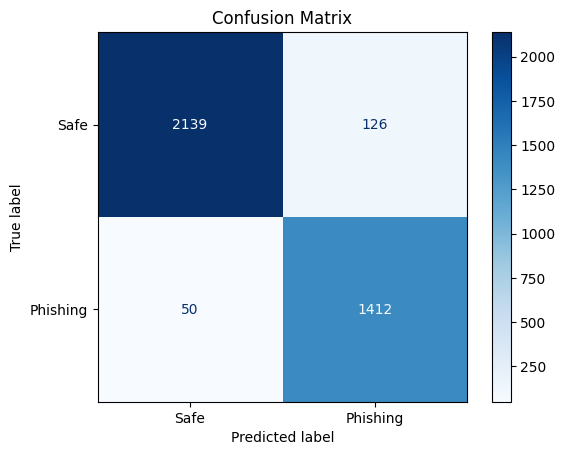

In [ ]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_score(y_test, y_pred_proba):.2f}")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR'); plt.ylabel('TPR')
plt.title('ROC Curve'); plt.legend()
plt.grid(True)
plt.show()

# PR Curve
precision_pr, recall_pr, _ = precision_recall_curve(y_test, y_pred_proba)
plt.figure(figsize=(6, 4))
plt.plot(recall_pr, precision_pr, label="PR Curve")
plt.xlabel('Recall'); plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

# confusion_matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Safe', 'Phishing'])

plt.figure(figsize=(5, 4))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix')
plt.grid(False)
plt.show()